In [1]:
import csv
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_list(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return lst

In [3]:
def find_ranks(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

In [4]:
#defining filedirectory
fileDir = os.path.dirname(os.path.realpath('__file__'))

In [5]:
#defining data frames
df = pd.DataFrame()

In [6]:
#reading data from csv
for directory, subdirectory, filenames in  os.walk(fileDir + '/data/raw_data/'):
    for filename in filenames:
        print("Working on file: " + filename + '....')
        dateparse = lambda x: pd.datetime.strptime(x, '%H:%M')
        df = pd.read_csv(os.path.join(directory, filename), parse_dates=['time'], date_parser=dateparse)

Working on file: train.csv....


In [7]:
#defining required columns
columns = ['state', 'location', 'group_size', 'homeowner', 'car_age', 'car_value', 'risk_factor', 
           'age_oldest', 'age_youngest', 'married_couple']

In [8]:
#subsetting data frame
df = df[columns]

In [9]:
#converting states into codes
df['state_code'] = df['state'].astype('category')
df['state_code'] = df['state_code'].cat.codes

In [10]:
#converting car values into codes
df['car_value'].fillna('z', inplace=True)
df['car_value_code'] = df['car_value'].astype('category')
df['car_value_code'] = df['car_value_code'].cat.codes

In [11]:
#columns to be converted to categories
columns = ['location', 'group_size', 'homeowner', 'risk_factor', 'married_couple', 'state_code', 'car_value_code']

In [12]:
#change data type to category
for col in columns:
    df[col] = df[col].astype('category')

# Feature selection

In [13]:
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

In [14]:
#Subset data frame to select only rows where RiskScore is not null
df = df[~ pd.isnull(df['risk_factor'])]

In [15]:
#copy data frame
df_copy = df.copy()

In [16]:
#define source and target columns
Y= df_copy['risk_factor']
df_copy.drop('risk_factor',axis=1,inplace=True)
df_copy.drop('state',axis=1,inplace=True)
df_copy.drop('car_value',axis=1,inplace=True)
X = df_copy

In [17]:
names = X.columns.values.tolist()
ranks = {}

In [18]:
#Linear Regression - Multicollinearity
lr = LinearRegression(normalize=True)
lr.fit(X, Y)
ranks["Linear regression"] = find_ranks(np.abs(lr.coef_), names)

In [19]:
#L1 Regularization for Linear Regression - adding additional constraint or penalty to the model to prevent overfitting since
#Linearregression does not work well with multiple variables
#Forces weak features to have zero coefficients
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = find_ranks(np.abs(lasso.coef_), names)

In [20]:
#Ridge Regression - adds L2 norm to reduce sparse solutions by Lasso
#forces the coefficient values to be spread out more equally
ridge = Ridge(alpha=7)
ridge.fit(X, Y)
ranks["Ridge"] = find_ranks(np.abs(ridge.coef_), names)

In [21]:
#random forest - for non linear relationships 
rf = RandomForestRegressor()
rf.fit(X,Y)
ranks["RF"] = find_ranks(rf.feature_importances_, names)

In [22]:
#Recursive feature elimination: selects features then repeatedly runs the model to get the best fit with rest of features 
# stop the search when 6 features are left (they will get equal scores)
rfe = RFE(lr, n_features_to_select=6)
rfe.fit(X,Y)
ranks["RFE"] = find_ranks(rfe.ranking_, names, order=-1)

In [23]:
rank_df = pd.DataFrame(ranks)
rank_df['Max-Rank'] = rank_df.max(axis=1)
rank_df['Avg-Rank'] = rank_df.mean(axis=1)

In [24]:
rank_df.sort("Avg-Rank", ascending = False)

,Lasso,Linear regression,RF,RFE,Ridge,Max-Rank,Avg-Rank
homeowner,0.00,1.00,0.02,1.00,1.00,1.00,0.670000
state_code,0.80,0.11,0.72,1.00,0.11,1.00,0.623333
car_age,1.00,0.14,0.45,1.00,0.14,1.00,0.621667
age_oldest,0.77,0.08,0.60,1.00,0.08,1.00,0.588333
married_couple,0.00,0.29,0.00,1.00,0.29,1.00,0.430000
age_youngest,0.44,0.06,0.33,0.67,0.06,0.67,0.371667
group_size,0.00,0.08,0.00,1.00,0.08,1.00,0.360000
location,0.00,0.00,1.00,0.00,0.00,1.00,0.333333
car_value_code,0.00,0.01,0.24,0.33,0.01,0.33,0.153333


# Divide into test and train data

In [25]:
#copy data frame
df_copy = df.copy()

In [26]:
#dropping not-required columns
df_copy.drop('state',axis=1,inplace=True)
df_copy.drop('car_value',axis=1,inplace=True)

In [27]:
#dividing the DF into two for test & train data
from sklearn.model_selection import train_test_split
train_risk, test_risk = train_test_split(df_copy, test_size = 0.2)

In [28]:
#inputs required for classification
train_y = train_risk['risk_factor']
train_X = train_risk.drop(['risk_factor'], axis = 1)

test_y = test_risk['risk_factor']
test_X = test_risk.drop(['risk_factor'], axis = 1)

# Logistic regression

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn import metrics
import matplotlib as mlp
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

In [30]:
#defining the model
model = LogisticRegression()

In [31]:
#training the train_X data on the model
model = model.fit(train_X,train_y)

In [32]:
#predecting 'LoanApproval' for train_X & test_X data
train_y_predicted = model.predict(train_X)
test_y_predicted = model.predict(test_X)

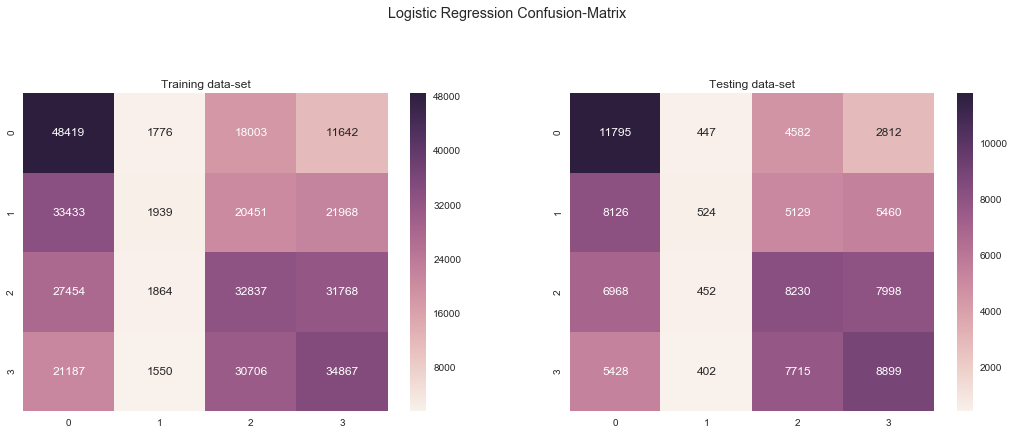

In [33]:
#preparing Confusion-matrix for train_X & test_X data
logistic_reg_conf_matrix_train = metrics.confusion_matrix(train_y, train_y_predicted)
logistic_reg_conf_matrix_test = metrics.confusion_matrix(test_y, test_y_predicted)

#plot on Confusion-matrix heatmap
fix, ax = plt.subplots(figsize=(16, 12))
plt.suptitle('Logistic Regression Confusion-Matrix')
plt.subplot(2, 2, 1)
plt.title('Training data-set');
sns.heatmap(logistic_reg_conf_matrix_train, annot=True,  fmt='d');

plt.subplot(2, 2, 2)
plt.title('Testing data-set');
sns.heatmap(logistic_reg_conf_matrix_test, annot=True,  fmt='d');

plt.show()

In [34]:
#calculating accuracy score
logistic_reg_acc_matrix_train = metrics.accuracy_score(train_y, train_y_predicted)
logistic_reg_acc_matrix_test = metrics.accuracy_score(test_y, test_y_predicted)
print('Logistic Regression accuracy')
print('Training data : ',logistic_reg_acc_matrix_train)
print('Testing data : ',logistic_reg_acc_matrix_test)

Logistic Regression accuracy
Training data :  0.347380128522
Testing data :  0.346581614038


In [35]:
#generating classification report
print('Logistic Regression classification reprot')

logistic_reg_class_report_train = metrics.classification_report(train_y, train_y_predicted)
print('Training data')
print(logistic_reg_class_report_train)

logistic_reg_class_report_test = metrics.classification_report(test_y, test_y_predicted)
print('Testing data')
print(logistic_reg_class_report_test)

Logistic Regression classification reprot
Training data
             precision    recall  f1-score   support

        1.0       0.37      0.61      0.46     79840
        2.0       0.27      0.02      0.05     77791
        3.0       0.32      0.35      0.34     93923
        4.0       0.35      0.39      0.37     88310

avg / total       0.33      0.35      0.31    339864

Testing data
             precision    recall  f1-score   support

        1.0       0.36      0.60      0.45     19636
        2.0       0.29      0.03      0.05     19239
        3.0       0.32      0.35      0.33     23648
        4.0       0.35      0.40      0.37     22444

avg / total       0.33      0.35      0.31     84967



# Random Forest 

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn import metrics
import matplotlib as mlp
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

In [37]:
#defining the model
model = RandomForestClassifier(n_estimators = 10)

In [38]:
#training the train_X data on the model
model = model.fit(train_X,train_y)

In [39]:
# View a list of the features and their importance scores
list(zip(train_X, model.feature_importances_))

[('location', 0.32218100334747729),
 ('group_size', 0.015133960267648915),
 ('homeowner', 0.012203451783607877),
 ('car_age', 0.15718687874259335),
 ('age_oldest', 0.12438307352427577),
 ('age_youngest', 0.12404293502133557),
 ('married_couple', 0.012857191686890267),
 ('state_code', 0.13731597110078644),
 ('car_value_code', 0.09469553452538447)]

In [40]:
#predecting 'LoanApproval' for train_X & test_X data
train_y_predicted = model.predict(train_X)
test_y_predicted = model.predict(test_X)

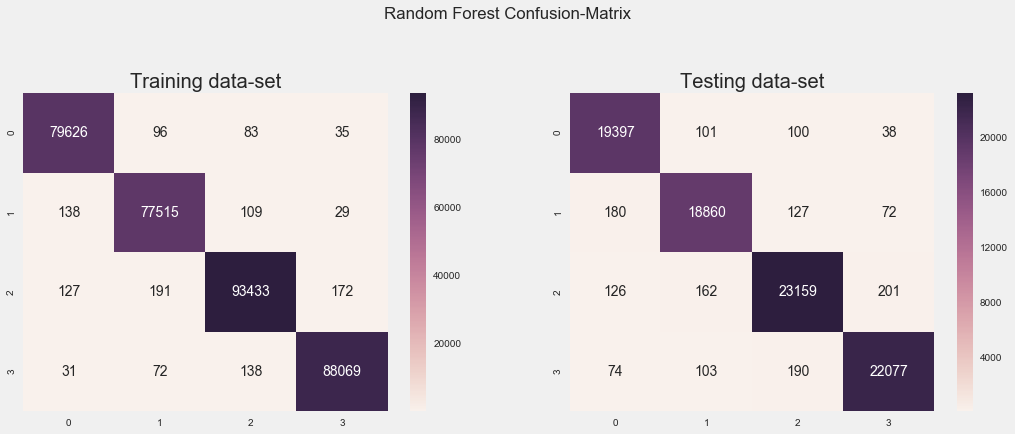

In [41]:
#preparing Confusion-matrix for train_X & test_X data
random_forest_conf_matrix_train = metrics.confusion_matrix(train_y, train_y_predicted)
random_forest_conf_matrix_test = metrics.confusion_matrix(test_y, test_y_predicted)

#plot on Confusion-matrix heatmap
fix, ax = plt.subplots(figsize=(16, 12))
plt.suptitle('Random Forest Confusion-Matrix')
plt.subplot(2, 2, 1)
plt.title('Training data-set');
sns.heatmap(random_forest_conf_matrix_train, annot=True,  fmt='d');

plt.subplot(2, 2, 2)
plt.title('Testing data-set');
sns.heatmap(random_forest_conf_matrix_test, annot=True,  fmt='d');

plt.show()

In [42]:
#calculating accuracy score
random_forest_acc_matrix_train = metrics.accuracy_score(train_y, train_y_predicted)
random_forest_acc_matrix_test = metrics.accuracy_score(test_y, test_y_predicted)
print('Random Forest accuracy')
print('Training data : ',random_forest_acc_matrix_train)
print('Testing data : ',random_forest_acc_matrix_test)

Random Forest accuracy
Training data :  0.996407386484
Testing data :  0.982652088458


In [43]:
#generating classification report
print('Random Forest classification reprot')

random_forest_class_report_train = metrics.classification_report(train_y, train_y_predicted)
print('Training data')
print(random_forest_class_report_train)

random_forest_class_report_test = metrics.classification_report(test_y, test_y_predicted)
print('Testing data')
print(random_forest_class_report_test)

Random Forest classification reprot
Training data
             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00     79840
        2.0       1.00      1.00      1.00     77791
        3.0       1.00      0.99      1.00     93923
        4.0       1.00      1.00      1.00     88310

avg / total       1.00      1.00      1.00    339864

Testing data
             precision    recall  f1-score   support

        1.0       0.98      0.99      0.98     19636
        2.0       0.98      0.98      0.98     19239
        3.0       0.98      0.98      0.98     23648
        4.0       0.99      0.98      0.98     22444

avg / total       0.98      0.98      0.98     84967

